### Importar o dataset


In [2]:
from dotenv import load_dotenv
import os
import pandas as pd
load_dotenv()

dfs = []
path_dados = os.getenv("PATH_DADOS")
for arquivo in os.listdir(path_dados):
    if arquivo.endswith('.parquet'):
        dfs.append(pd.read_parquet(f'{path_dados}/{arquivo}'))


SEED = 1303

df = pd.concat(dfs,ignore_index=True)
df_rotulados = pd.read_csv(f'{path_dados}/dados_rotulados.csv')

In [3]:
df_rotulados.sentiment.unique()

array(['Negative', 'Positive', 'Neutral', nan], dtype=object)

In [4]:
import pandas as pd
import os

# Caminho correto dos dados rotulados
arquivo_entrada = f'{path_dados}/dados_rotulados.csv'
arquivo_saida = f'{path_dados}/dados_rotulados_filtrados.csv'

# Verifica se o arquivo existe antes de continuar
if not os.path.exists(arquivo_entrada):
    print(f"Erro: O arquivo '{arquivo_entrada}' não foi encontrado. Verifique o caminho!")
else:
    # Carregando os dados rotulados
    df_rotulados = pd.read_csv(arquivo_entrada)

    # Exibe as primeiras linhas para entender o formato
    print("Primeiras linhas do DataFrame original:")
    #print(df_rotulados.head())

    print(df_rotulados.sentiment.unique())

    # Dicionário de mapeamento para converter sentimentos em valores numéricos
    mapeamento_sentimento = {
        'Positive': 1,
        'Negative': 0,
    }

    # Verifica se a coluna 'sentiment' existe no DataFrame
    if 'sentiment' not in df_rotulados.columns:
        print("Erro: A coluna 'sentiment' não existe no DataFrame.")
    else:
        # Aplicando o mapeamento na coluna 'sentiment'
        df_rotulados['sentiment'] = df_rotulados['sentiment'].map(mapeamento_sentimento)

        # Removendo valores neutros (0) e não classificados (NaN)
        df_rotulados = df_rotulados.dropna(subset=['sentiment'])

        # Convertendo a coluna 'sentiment' para inteiro (opcional)
        df_rotulados['sentiment'] = df_rotulados['sentiment'].astype(int)

        # Salvando o novo arquivo filtrado
        df_rotulados.to_csv(arquivo_saida, index=False)

        print(f"Arquivo filtrado salvo com sucesso: {arquivo_saida}")


Primeiras linhas do DataFrame original:
['Negative' 'Positive' 'Neutral' nan]
Arquivo filtrado salvo com sucesso: dados/dados_rotulados_filtrados.csv


## Aplicação das LabelFuntions do Snorkel

Aqui será aplicada as labelfunctions do Snorkel baseadas em regex, em conjunto com os dados rotulados manualmente por LiraFefa

In [5]:
from snorkel.labeling import labeling_function,PandasLFApplier
import re

# Define the label mappings for convenience
ABSTER = -1
NEGATIVO = 0
POSITIVO = 1

# Expressões Regulares - Termos que quero encontrar
regex_a = re.compile(r'\bcumpriment[ao]\s+individual\s+de\s+senten[çc]a\b', re.IGNORECASE) # Encontrar "cumprimento individual de sentença"
regex_b = re.compile(r'\bsindicato\b', re.IGNORECASE)  # Encontrar "sindicato"
regex_c = re.compile(r'\bexecuç[ãa]\s+individual\b', re.IGNORECASE) # Encontrar "EXECUÇÃO INDIVIDUAL"
regex_d = re.compile(r'\bóbit[oa]\s+do\s+instituidor\b', re.IGNORECASE)  # Encontrar "óbito do instituidor"
regex_e = re.compile(r'\bparidade\b', re.IGNORECASE)  # Procurar "paridade"
regex_f = re.compile(r'\bsenten[çc]a\s+coletiva\b', re.IGNORECASE) #Encontrar " sentença coletiva"
regex_g = re.compile(r'\bexecu[çc][ãa]o\s+origin[áa]ria\b', re.IGNORECASE) #Encontrar " execução originária"
regex_h = re.compile(r'\bnos\s+autos\s+da\s+aç[ãa]o\s+coletiva\b', re.IGNORECASE)  # Encontrar "nos autos da ação coletiva"
regex_i = re.compile(r'\bherdeir[oa]\b', re.IGNORECASE)  # Encontrar "herdeiros" com ou sem acento

# Expressões Regulares - Termos que NÃO quero encontrar
regex_nao_encontrar_a = re.compile(r'\baposentador[ií]a\b', re.IGNORECASE)  # Encontrar "APOSENTADORIA"
regex_nao_encontrar_b = re.compile(r'\b[bB]enef[íi]cio\s+previdenci[áa]rio\b', re.IGNORECASE) # Encontrar "benefício previdenciário"
regex_nao_encontrar_c = re.compile(r'\bconcurso\s+público\b', re.IGNORECASE)  # Encontrar "concurso público"
regex_nao_encontrar_d = re.compile(r'\bfinanciamento\b', re.IGNORECASE)  # Encontrar "financiamento"
regex_nao_encontrar_e = re.compile(r'\btributo\b', re.IGNORECASE)  # Encontrar "tributo"
regex_nao_encontrar_f = re.compile(r'\bd[ií]vida\s+ativa\b', re.IGNORECASE)  # Encontrar "dívida ativa"
regex_nao_encontrar_g = re.compile(r'\bcr[ée]dito\s+tribut[áa]rio\b', re.IGNORECASE)  # Encontrar "crédito tributário"
regex_nao_encontrar_h = re.compile(r'\bf[ií]scal\b', re.IGNORECASE)  # Encontrar "fiscal"
regex_nao_encontrar_i = re.compile(r'\binvalidez\b', re.IGNORECASE)  # Encontrar "invalidez"
regex_nao_encontrar_j = re.compile(r'\bdiploma\b', re.IGNORECASE)  # Encontrar "diploma"
regex_nao_encontrar_k = re.compile(r'\bpensão\s+por\s+morte\b', re.IGNORECASE)  # Encontrar "pensão por morte"
regex_nao_encontrar_l = re.compile(r'\bplano\s+de\s+saúde\b', re.IGNORECASE)  # Encontrar "plano de saúde"
regex_nao_encontrar_m = re.compile(r'\bcofins\b', re.IGNORECASE)  # Encontrar "COFINS"
regex_nao_encontrar_n = re.compile(r'\baposentadoria\s+por\s+idade\s+rural\b', re.IGNORECASE)  # Encontrar "APOSENTADORIA POR IDADE RURAL"
regex_nao_encontrar_o = re.compile(r'\bremédio\b', re.IGNORECASE)  # Encontrar "remédio"
regex_nao_encontrar_p = re.compile(r'\baposentadoria\s+especial\b', re.IGNORECASE)  # Encontrar "aposentadoria especial"

@labeling_function()
def labeling_function_positiva_a(df):
    if regex_a.search(df.texto):
        return POSITIVO
    return ABSTER

@labeling_function()
def labeling_function_positiva_b(df):
    if regex_b.search(df.texto):
        return POSITIVO
    return ABSTER

@labeling_function()
def labeling_function_positiva_c(df):
    if regex_c.search(df.texto):
        return POSITIVO
    return ABSTER

@labeling_function()
def labeling_function_positiva_d(df):
    if regex_d.search(df.texto):
        return POSITIVO
    return ABSTER

@labeling_function()
def labeling_function_positiva_e(df):
    if regex_e.search(df.texto):
        return POSITIVO
    return ABSTER

@labeling_function()
def labeling_function_positiva_g(df):
    if regex_g.search(df.texto):
        return POSITIVO
    return ABSTER


@labeling_function()
def labeling_function_positiva_f(df):
    if regex_f.search(df.texto):
        return POSITIVO
    return ABSTER

@labeling_function()
def labeling_function_positiva_dg(df):
    if regex_g.search(df.texto):
        return POSITIVO
    return ABSTER

@labeling_function()
def labeling_function_positiva_h(df):
    if regex_h.search(df.texto):
        return POSITIVO
    return ABSTER

@labeling_function()
def labeling_function_positiva_i(df):
    if regex_i.search(df.texto):
        return POSITIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_a(df):
    if regex_nao_encontrar_a.search(df.texto):
        return NEGATIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_b(df):
    if regex_nao_encontrar_b.search(df.texto):
        return NEGATIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_c(df):
    if regex_nao_encontrar_c.search(df.texto):
        return NEGATIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_d(df):
    if regex_nao_encontrar_d.search(df.texto):
        return NEGATIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_e(df):
    if regex_nao_encontrar_e.search(df.texto):
        return NEGATIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_f(df):
    if regex_nao_encontrar_f.search(df.texto):
        return NEGATIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_g(df):
    if regex_nao_encontrar_g.search(df.texto):
        return NEGATIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_h(df):
    if regex_nao_encontrar_h.search(df.texto):
        return NEGATIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_i(df):
    if regex_nao_encontrar_i.search(df.texto):
        return NEGATIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_j(df):
    if regex_nao_encontrar_j.search(df.texto):
        return NEGATIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_k(df):
    if regex_nao_encontrar_k.search(df.texto):
        return NEGATIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_l(df):
    if regex_nao_encontrar_l.search(df.texto):
        return NEGATIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_m(df):
    if regex_nao_encontrar_m.search(df.texto):
        return NEGATIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_n(df):
    if regex_nao_encontrar_n.search(df.texto):
        return NEGATIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_o(df):
    if regex_nao_encontrar_o.search(df.texto):
        return NEGATIVO
    return ABSTER

@labeling_function()
def labeling_function_negativa_p(df):
    if regex_nao_encontrar_p.search(df.texto):
        return NEGATIVO
    return ABSTER

In [6]:
from snorkel.labeling import LFAnalysis
from snorkel.labeling import PandasLFApplier
from sklearn.model_selection import train_test_split
import numpy as np


lfs = [labeling_function_negativa_a,labeling_function_negativa_b,labeling_function_negativa_c,
       labeling_function_negativa_d,labeling_function_negativa_e,labeling_function_negativa_f,
       labeling_function_negativa_g,labeling_function_negativa_h,labeling_function_negativa_i,
       labeling_function_negativa_j,labeling_function_negativa_k,labeling_function_negativa_l,
       labeling_function_negativa_m,labeling_function_negativa_n,labeling_function_negativa_o,
       labeling_function_negativa_p,
       
       labeling_function_positiva_a,labeling_function_positiva_b,labeling_function_positiva_c,
       labeling_function_positiva_d,labeling_function_positiva_e,labeling_function_positiva_f,
       labeling_function_positiva_g,labeling_function_positiva_h,labeling_function_positiva_i
    
]


X = df_rotulados.drop(columns=['sentiment'])
y = df_rotulados.loc[:,'sentiment']
X_train, X_intermediario, y_train, y_intermediario = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_dev, X_test, y_dev, y_test = train_test_split(X_intermediario, y_intermediario, test_size=0.2, random_state=SEED, stratify=y_intermediario)

X_test.to_parquet('Dados_de_teste.parquet')
np.save('rotulos_teste.npy',y_test)
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=X_train)


print(f'Convergencias das Label functions no Dataset de desenvolvimento {LFAnalysis(L=L_train, lfs=lfs).label_coverage()*100}%')





100%|██████████| 2324/2324 [00:10<00:00, 221.81it/s]

Convergencias das Label functions no Dataset de desenvolvimento 60.71428571428571%


In [1]:
import numpy as np
display(LFAnalysis(L=L_train, lfs=lfs).lf_summary(Y = np.array(y_train)))

NameError: name 'LFAnalysis' is not defined

In [ ]:
import time
from multiprocessing import cpu_count

#from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import (RandomForestClassifier, StackingClassifier,
                              ExtraTreesClassifier)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, average_precision_score,
                             balanced_accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix, f1_score,
                             matthews_corrcoef)
from sklearn.model_selection import (StratifiedKFold, cross_val_predict,
                                     train_test_split)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
#from xgboost import XGBClassifier



def train_models(X, y):
    random_state = 42

    # Spot Check
    models = []
    models.append(('Calibrated-LSVC', CalibratedClassifierCV(LinearSVC(random_state=42, class_weight='balanced', dual='auto'))))
    models.append(('LR', LogisticRegression(random_state=42, n_jobs=-1, class_weight='balanced')))
    models.append(('RF', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')))

    #models.append(('XGB', XGBClassifier(random_state=42, n_jobs=-1, class_weight='balanced', verbosity=0)))
    models.append(('MLP', MLPClassifier(random_state=42)))
    models.append(('SGD', SGDClassifier(random_state=42, n_jobs=-1, class_weight='balanced')))
    models.append(('NB', MultinomialNB()))
    models.append(('LSVC', LinearSVC(random_state=42, class_weight='balanced')))
    models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
    models.append(('DT', DecisionTreeClassifier(random_state=42, class_weight='balanced')))
    models.append(('ExtraTrees', ExtraTreesClassifier(random_state=42, n_jobs=-1, class_weight='balanced')))

    #models.append(('LGBM', LGBMClassifier(random_state=42, n_jobs=-1, class_weight='balanced', verbose=-1)))

    results = []
    creports = []

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    for name, model in models:
        start_time = time.time()

        try:
            pred = cross_val_predict(estimator=model, X=X, y=y, cv=cv,
                                     method="predict", n_jobs=2)
        except Exception as e:
            print(f'Error {name} - {e}')
            continue

        f1 = f1_score(y, pred, average='micro')
        bacc = balanced_accuracy_score(y, pred)
        acc = accuracy_score(y, pred)
        cr = classification_report(y, pred)
        mcc = matthews_corrcoef(y, pred)
        cm = confusion_matrix(y, pred)
        creports.append([name, cr, cm])

        elapsed = time.time() - start_time
        results.append([name, f1, bacc, acc, mcc, elapsed, cm, cr,])

        msg = f'Name: {name} - F1: {f1:.4f} - BACC: {bacc:.4f} - ACC: {acc:.4f} - MCC: {mcc:.4f} - Elapsed: {elapsed:.2f}s'
        print(msg)
        print(cr)
        print(cm)
        print('*' * 20, '\n')

    columns = ['Model', 'F1', 'BACC', 'ACC', 'MCC', 'Total Time', 'Confusion Matrix', 'Classification Report']
    df_results = pd.DataFrame(results, columns=columns)
    df_results['Confusion Matrix'] = df_results['Confusion Matrix'].apply(lambda x: str(x))

    return df_results, creports


#df_results, creports = train_models(X_dev, y_dev)

#df_results.sort_values(by='MCC', ascending=False)

In [ ]:
from sklearn.model_selection import GridSearchCV
"""
# Define a grade de hiperparâmetros
param_grid = {
    # Diferentes combinações para as duas camadas ocultas:
    'hidden_layer_sizes': [(50, 50), (100, 50), (100, 100), (150, 50)],
    # Funções de ativação: tanh e logistic (sigmoid)
    'activation': ['tanh', 'logistic'],
    # Solver pode ser ajustado também, aqui usamos o 'adam' como exemplo
    'solver': ['adam']
}

# Cria o classificador MLP
mlp = MLPClassifier(max_iter=500, random_state=42)

# Configura o GridSearchCV para buscar os melhores parâmetros
grid_search = GridSearchCV(estimator=mlp,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

# Executa a busca nos dados de treinamento
grid_search.fit(X_dev, y_dev)

# Exibe os melhores parâmetros e a pontuação associada
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)
print("Melhor pontuação (CV): {:.4f}".format(grid_search.best_score_))

# Avalia o modelo no conjunto de teste
score = grid_search.score(X_dev, y_dev)
"""

In [7]:
"""
# Exibe os melhores parâmetros e a pontuação associada
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)
print("Melhor pontuação (CV): {:.4f}".format(grid_search.best_score_))

# Avalia o modelo no conjunto de teste
score = grid_search.score(X_dev, y_dev)
"""

'\n# Exibe os melhores parâmetros e a pontuação associada\nprint("Melhores parâmetros encontrados:")\nprint(grid_search.best_params_)\nprint("Melhor pontuação (CV): {:.4f}".format(grid_search.best_score_))\n\n# Avalia o modelo no conjunto de teste\nscore = grid_search.score(X_dev, y_dev)\n'

In [ ]:
X_train

,Unnamed: 0,annotation_id,annotator,classeJudicial,created_at,id,lead_time,numeroProcesso,resumo,texto,ufClasse,updated_at
50,4698,51,1,APELAÇÃO CÍVEL,2025-02-17T23:43:02.388439Z,51,7.951,08026869420234058100,"(PROCESSO: 08026869420234058100, APELAÇÃO CÍVE...",\r\n EMENTA \r\n ADMINISTRATIVO. FIES. PRORROG...,NaN,2025-02-17T23:43:02.388439Z
1404,21072,1405,1,APELAÇÃO CÍVEL,2025-02-19T12:40:57.283505Z,1405,5.650,08214877920194058300,"(PROCESSO: 08214877920194058300, APELAÇÃO CÍVE...",\r\n ADMINISTRATIVO. SERVIDOR PÚBLICO FEDERAL....,NaN,2025-02-19T12:40:57.283505Z
884,14340,885,1,AGRAVO DE INSTRUMENTO,2025-02-18T18:38:28.783276Z,885,4.893,08085425520244050000,"(PROCESSO: 08085425520244050000, AGRAVO DE INS...",\r\n PROCESSO Nº: 0808542-55.2024.4.05.0000 - ...,NaN,2025-02-18T18:38:28.783276Z
2319,10548,2320,1,APELAÇÃO CÍVEL,2025-02-19T20:49:53.234909Z,2320,1.813,08029560920234058201,"(PROCESSO: 08029560920234058201, APELAÇÃO CÍVE...",PROCESSO Nº: 0802956-09.2023.4.05.8201 - APELA...,NaN,2025-02-19T20:49:53.234909Z
1740,20905,1741,1,APELAÇÃO CÍVEL,2025-02-19T14:24:49.258787Z,1741,5.146,08026523820224058300,"(PROCESSO: 08026523820224058300, APELAÇÃO CÍVE...",\r\n Ementa \r\n \r\n Processual Civil. Apelaç...,NaN,2025-02-19T14:24:49.258787Z
...,...,...,...,...,...,...,...,...,...,...,...,...
1850,11983,1851,1,APELAÇÃO CÍVEL,2025-02-19T14:51:18.053347Z,1851,4.212,08096657220234058100,"(PROCESSO: 08096657220234058100, APELAÇÃO CÍVE...",\r\n EMENTA \r\n PROCESSUAL CIVIL. REEXPEDIÇÃO...,NaN,2025-02-19T14:51:18.053347Z
688,17087,689,1,APELAÇÃO CÍVEL,2025-02-18T15:39:12.807491Z,689,10.257,08018091420244058200,"(PROCESSO: 08018091420244058200, APELAÇÃO CÍVE...",PROCESSO Nº: 0801809-14.2024.4.05.8200 - APELA...,NaN,2025-02-18T15:39:12.807491Z
1469,6945,1470,1,APELAÇÃO CÍVEL,2025-02-19T12:51:54.465867Z,1470,4.837,08018127720228150261,"(PROCESSO: 08018127720228150261, APELAÇÃO CÍVE...",\r\n EMENTA \r\n PREVIDENCIÁRIO. SEGURADA ESPE...,NaN,2025-02-19T12:51:54.465867Z
2673,8873,2674,1,AGRAVO DE INSTRUMENTO,2025-02-19T22:19:24.079616Z,2674,4.666,08077527120244050000,"(PROCESSO: 08077527120244050000, AGRAVO DE INS...",\r\n CUMPRIMENTO INDIVIDUAL DE SENTENÇA COLETI...,NaN,2025-02-19T22:19:24.079616Z


In [ ]:
# Cria o classificador MLP
tfidf_vec_ssl = TfidfVectorizer(ngram_range=(1,3), strip_accents='unicode', lowercase=True, max_features=3000, min_df=10)

X_vec = tfidf_vec_ssl.fit_transform(X_train.texto)
X_vec = X_vec.toarray()
y_vec = y_train
print(X_vec.shape)

grid_search={'activation': 'tanh', 'hidden_layer_sizes': (100, 50), 'solver': 'adam'}
mlp = MLPClassifier(hidden_layer_sizes=grid_search['hidden_layer_sizes'],activation=grid_search['activation'],max_iter=500, random_state=42)

mlp.fit(X_vec, y_vec)

(464, 12)


MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 50), max_iter=500,
              random_state=42)

In [ ]:
from snorkel.preprocess import preprocessor
lfs = [labeling_function_negativa_a,labeling_function_negativa_b,labeling_function_negativa_c,
       labeling_function_negativa_d,labeling_function_negativa_e,labeling_function_negativa_f,
       labeling_function_negativa_g,labeling_function_negativa_h,labeling_function_negativa_i,
       labeling_function_negativa_j,labeling_function_negativa_k,labeling_function_negativa_l,
       labeling_function_negativa_m,labeling_function_negativa_n,labeling_function_negativa_o,
       labeling_function_negativa_p,
       
       labeling_function_positiva_a,labeling_function_positiva_b,labeling_function_positiva_c,
       labeling_function_positiva_d,labeling_function_positiva_e,labeling_function_positiva_f,
       labeling_function_positiva_g,labeling_function_positiva_h,labeling_function_positiva_i
    
]

# Define a preprocessor function that adds a predicted label and score to a given example using a stacked classifier
@preprocessor(memoize=True)
def semi_superv_stacked_classifier(x):
    # Vectorize the text of the example using a TF-IDF vectorizer trained on the semi-supervised dataset
    vectorized_text = tfidf_vec_ssl.transform([x.texto])
    # Use the stacked classifier trained on the semi-supervised dataset to predict the label probabilities for the example
    pred_proba = mlp.predict_proba(vectorized_text)
    # Determine the predicted label and score based on the predicted probabilities
    pred = np.argmax(pred_proba, axis=1)
    x.label_pred_ssl = POSITIVO if pred == 1 else NEGATIVO
    x.score_ssl = pred_proba[0][pred]
    # Return the example with the predicted label and score added
    return x

@labeling_function(pre=[semi_superv_stacked_classifier])
def lf_ssl(x):
    if x.score_ssl >= 0.60: # If we don't apply this threshold, we'd get 100% coverage. But we'd also get a wrong labels.
        if x.label_pred_ssl == 1:
            return POSITIVO
        elif x.label_pred_ssl == 0:
            return NEGATIVO
    else:
        return ABSTER
lfs_mlp = lfs
lfs_mlp.append(lf_ssl)



In [ ]:
applier = PandasLFApplier(lfs=lfs_mlp)
L_train = applier.apply(df=X_train)
display(LFAnalysis(L=L_train, lfs=lfs_mlp).lf_summary(Y = np.array(y_train)))


L_dev = applier.apply(df=X_dev)
display(LFAnalysis(L=L_dev, lfs=lfs_mlp).lf_summary(Y = np.array(y_dev)))


100%|██████████| 2324/2324 [00:16<00:00, 141.89it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
labeling_function_negativa_a,0,[0],0.109725,0.109725,0.015491,243,12,0.952941
labeling_function_negativa_b,1,[0],0.056368,0.056368,0.008606,124,7,0.946565
labeling_function_negativa_c,2,[0],0.030981,0.030981,0.003873,65,7,0.902778
labeling_function_negativa_d,3,[0],0.093804,0.093804,0.004303,209,9,0.958716
labeling_function_negativa_e,4,[0],0.051635,0.051635,0.003442,116,4,0.966667
labeling_function_negativa_f,5,[0],0.041308,0.041308,0.002582,92,4,0.958333
labeling_function_negativa_g,6,[0],0.039587,0.039587,0.001721,90,2,0.978261
labeling_function_negativa_h,7,[0],0.200086,0.200086,0.015491,442,23,0.950538
labeling_function_negativa_i,8,[0],0.024527,0.024527,0.001291,57,0,1.000000
labeling_function_negativa_j,9,[0],0.050344,0.050344,0.006454,107,10,0.914530


100%|██████████| 464/464 [00:03<00:00, 135.21it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
labeling_function_negativa_a,0,[0],0.125000,0.122845,0.019397,57,1,0.982759
labeling_function_negativa_b,1,[0],0.062500,0.062500,0.012931,29,0,1.000000
labeling_function_negativa_c,2,[0],0.040948,0.040948,0.002155,17,2,0.894737
labeling_function_negativa_d,3,[0],0.066810,0.066810,0.004310,28,3,0.903226
labeling_function_negativa_e,4,[0],0.053879,0.053879,0.002155,25,0,1.000000
labeling_function_negativa_f,5,[0],0.036638,0.036638,0.002155,16,1,0.941176
labeling_function_negativa_g,6,[0],0.034483,0.034483,0.000000,16,0,1.000000
labeling_function_negativa_h,7,[0],0.170259,0.170259,0.006466,73,6,0.924051
labeling_function_negativa_i,8,[0],0.021552,0.021552,0.002155,10,0,1.000000
labeling_function_negativa_j,9,[0],0.036638,0.036638,0.000000,17,0,1.000000


In [ ]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train,Y_dev =y_train, n_epochs=500, log_freq=100, seed=10,class_balance=[0.881,0.119])

L_dev = applier.apply(df=X_dev)
label_model_pred = label_model.predict(L=L_dev)

print(f'\n\nClassification report for label model: \n{classification_report(y_dev.values, label_model_pred)}')
print(f'Number of abstains: {np.count_nonzero(label_model_pred == -1)}')


INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 500/500 [00:00<00:00, 557.71epoch/s]
INFO:root:Finished Training
100%|██████████| 464/464 [00:04<00:00, 99.07it/s] 



Classification report for label model: 
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       407
           1       0.70      0.56      0.62        57

    accuracy                           0.92       464
   macro avg       0.82      0.76      0.79       464
weighted avg       0.91      0.92      0.91       464

Number of abstains: 0


In [ ]:
predict_prob_label_model = label_model.predict_proba(L=L_dev)

predict_prob_label_model_filter = [ np.amax(x) for x in predict_prob_label_model if np.max(x)>0.9]

len(predict_prob_label_model_filter)/len(predict_prob_label_model)



0.9310344827586207

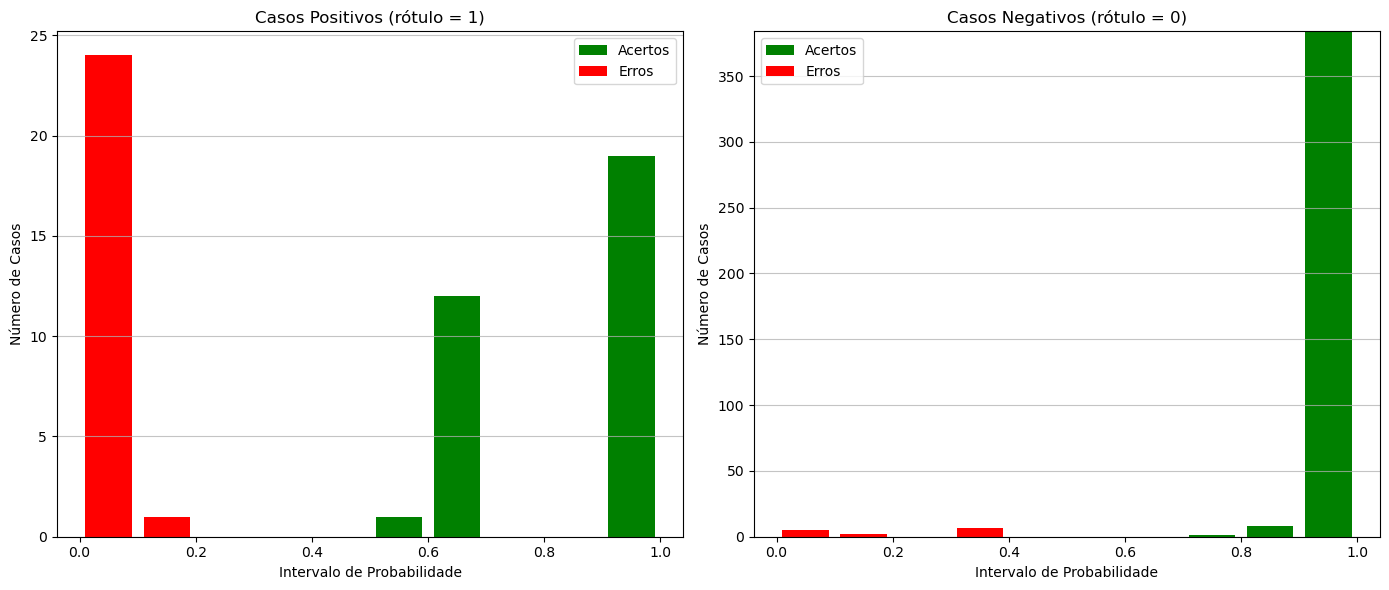

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supondo que:
# - predict_prob_label_model = label_model.predict_proba(L=L_dev)
# - y_dev contém os rótulos reais
# Se predict_prob_label_model for uma matriz com duas colunas, usamos a probabilidade da classe 1:


# Caso y_dev não seja um array numpy:
y_dev = np.array(y_dev)

# Definindo o threshold (limiar) e os intervalos (bins)
threshold = 0.5
bins = np.linspace(0, 1, 11)  # 10 intervalos: [0,0.1), [0.1,0.2), ..., [0.9,1]

def contar_por_bin(pred_probs, is_positive, threshold, bins):
    """
    Conta, para cada intervalo (bin), quantos casos foram classificados corretamente (acertos)
    e quantos foram classificados incorretamente (erros).
    
    Para casos positivos (is_positive=True): acerto se a probabilidade >= threshold.
    Para casos negativos (is_positive=False): acerto se a probabilidade < threshold.
    """
    acertos = np.zeros(len(bins) - 1)
    erros = np.zeros(len(bins) - 1)
    
    # Determina o índice do bin para cada probabilidade
    indices = np.digitize(pred_probs, bins) - 1  # ajuste para que os índices iniciem em 0
    
    for i, idx in enumerate(indices):
        # Ignora índices fora do intervalo
        if idx < 0 or idx >= len(acertos):
            continue
        if is_positive:
            if pred_probs[i] >= threshold:
                acertos[idx] += 1
            else:
                erros[idx] += 1
        else:
            if pred_probs[i] < threshold:
                acertos[idx] += 1
            else:
                erros[idx] += 1
    return acertos, erros

# Separa os casos positivos e negativos
mask_pos = (y_dev == 1)
mask_neg = (y_dev == 0)

pred_prob_pos = predict_prob_label_model[mask_pos,1]
pred_prob_neg = predict_prob_label_model[mask_neg,0]

# Conta acertos e erros por bin para cada grupo
acertos_pos, erros_pos = contar_por_bin(pred_prob_pos, is_positive=True, threshold=threshold, bins=bins)
acertos_neg, erros_neg = contar_por_bin(pred_prob_neg, is_positive=True, threshold=threshold, bins=bins)

# Calcula os centros dos bins para o eixo x
centros_bins = (bins[:-1] + bins[1:]) / 2

# Cria os gráficos
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico para casos positivos (rótulo = 1)
axs[0].bar(centros_bins, acertos_pos, width=0.08, label='Acertos', color='green')
axs[0].bar(centros_bins, erros_pos, width=0.08, bottom=acertos_pos, label='Erros', color='red')
axs[0].set_title('Casos Positivos (rótulo = 1)')
axs[0].set_xlabel('Intervalo de Probabilidade')
axs[0].set_ylabel('Número de Casos')
axs[0].legend()
axs[0].grid(axis='y', alpha=0.75)

# Gráfico para casos negativos (rótulo = 0)
axs[1].bar(centros_bins, acertos_neg, width=0.08, label='Acertos', color='green')
axs[1].bar(centros_bins, erros_neg, width=0.08, bottom=acertos_neg, label='Erros', color='red')
axs[1].set_title('Casos Negativos (rótulo = 0)')
axs[1].set_xlabel('Intervalo de Probabilidade')
axs[1].set_ylabel('Número de Casos')
axs[1].legend()
axs[1].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()


In [ ]:
# Suponha que n seja o número de partes desejadas
n = 100  # ajuste conforme necessário

# Calcula o tamanho de cada parte
chunk_size = len(df) // n

for i in range(n):
    inicio = i * chunk_size
    # Na última iteração, pega o restante do DataFrame
    fim = len(df) if i == n - 1 else (i + 1) * chunk_size
    
    # Cria uma cópia da parte do DataFrame para evitar warnings de atribuição
    df_parcial = df.iloc[inicio:fim].copy()
    
    # Aplica o pipeline de processamento
    L_parcial = applier.apply(df=df_parcial)
    pred_parcial = label_model.predict_proba(L=L_parcial)
    
    # Atribui as probabilidades preditas à coluna 'pred_prob'
    df_parcial['pred_prob'] = pred_parcial.tolist()
    
    # Define o caminho de salvamento com o sufixo incremental
    caminho = f'{path_dados}/df_com_pred_prob_final_{i+1}.parquet'
    df_parcial.to_parquet(caminho)
    
    print(f'Parte {i+1} salva em: {caminho}')

100%|██████████| 5022/5022 [00:06<00:00, 791.38it/s]


Parte 1 salva em: dados/df_com_pred_prob_final_1.parquet


100%|██████████| 5022/5022 [00:10<00:00, 492.41it/s]


Parte 2 salva em: dados/df_com_pred_prob_final_2.parquet


100%|██████████| 5022/5022 [00:12<00:00, 403.00it/s]


Parte 3 salva em: dados/df_com_pred_prob_final_3.parquet


100%|██████████| 5022/5022 [00:18<00:00, 264.70it/s]


Parte 4 salva em: dados/df_com_pred_prob_final_4.parquet


100%|██████████| 5022/5022 [00:16<00:00, 300.79it/s]


Parte 5 salva em: dados/df_com_pred_prob_final_5.parquet


100%|██████████| 5022/5022 [00:17<00:00, 280.51it/s]


Parte 6 salva em: dados/df_com_pred_prob_final_6.parquet


100%|██████████| 5022/5022 [00:15<00:00, 327.68it/s]


Parte 7 salva em: dados/df_com_pred_prob_final_7.parquet


100%|██████████| 5022/5022 [00:15<00:00, 314.67it/s]


Parte 8 salva em: dados/df_com_pred_prob_final_8.parquet


100%|██████████| 5022/5022 [00:17<00:00, 294.69it/s]


Parte 9 salva em: dados/df_com_pred_prob_final_9.parquet


100%|██████████| 5022/5022 [00:21<00:00, 228.48it/s]


Parte 10 salva em: dados/df_com_pred_prob_final_10.parquet


100%|██████████| 5022/5022 [00:25<00:00, 199.61it/s]


Parte 11 salva em: dados/df_com_pred_prob_final_11.parquet


100%|██████████| 5022/5022 [00:18<00:00, 275.08it/s]


Parte 12 salva em: dados/df_com_pred_prob_final_12.parquet


100%|██████████| 5022/5022 [00:11<00:00, 451.10it/s]


Parte 13 salva em: dados/df_com_pred_prob_final_13.parquet


100%|██████████| 5022/5022 [00:13<00:00, 371.73it/s]


Parte 14 salva em: dados/df_com_pred_prob_final_14.parquet


100%|██████████| 5022/5022 [00:16<00:00, 300.74it/s]


Parte 15 salva em: dados/df_com_pred_prob_final_15.parquet


100%|██████████| 5022/5022 [00:16<00:00, 301.99it/s]


Parte 16 salva em: dados/df_com_pred_prob_final_16.parquet


100%|██████████| 5022/5022 [00:19<00:00, 258.98it/s]


Parte 17 salva em: dados/df_com_pred_prob_final_17.parquet


100%|██████████| 5022/5022 [00:19<00:00, 257.97it/s]


Parte 18 salva em: dados/df_com_pred_prob_final_18.parquet


100%|██████████| 5022/5022 [00:22<00:00, 224.95it/s]


Parte 19 salva em: dados/df_com_pred_prob_final_19.parquet


100%|██████████| 5022/5022 [00:27<00:00, 185.03it/s]


Parte 20 salva em: dados/df_com_pred_prob_final_20.parquet


100%|██████████| 5022/5022 [00:14<00:00, 342.44it/s]


Parte 21 salva em: dados/df_com_pred_prob_final_21.parquet


100%|██████████| 5022/5022 [00:13<00:00, 368.54it/s]


Parte 22 salva em: dados/df_com_pred_prob_final_22.parquet


100%|██████████| 5022/5022 [00:16<00:00, 296.99it/s]


Parte 23 salva em: dados/df_com_pred_prob_final_23.parquet


100%|██████████| 5022/5022 [00:20<00:00, 250.37it/s]


Parte 24 salva em: dados/df_com_pred_prob_final_24.parquet


100%|██████████| 5022/5022 [00:36<00:00, 137.83it/s]


Parte 25 salva em: dados/df_com_pred_prob_final_25.parquet


100%|██████████| 5022/5022 [00:24<00:00, 207.09it/s]


Parte 26 salva em: dados/df_com_pred_prob_final_26.parquet


100%|██████████| 5022/5022 [00:21<00:00, 228.87it/s]


Parte 27 salva em: dados/df_com_pred_prob_final_27.parquet


100%|██████████| 5022/5022 [00:20<00:00, 245.30it/s]


Parte 28 salva em: dados/df_com_pred_prob_final_28.parquet


100%|██████████| 5022/5022 [00:13<00:00, 379.60it/s]


Parte 29 salva em: dados/df_com_pred_prob_final_29.parquet


100%|██████████| 5022/5022 [00:15<00:00, 328.28it/s]


Parte 30 salva em: dados/df_com_pred_prob_final_30.parquet


100%|██████████| 5022/5022 [00:15<00:00, 320.86it/s]


Parte 31 salva em: dados/df_com_pred_prob_final_31.parquet


100%|██████████| 5022/5022 [00:16<00:00, 304.11it/s]


Parte 32 salva em: dados/df_com_pred_prob_final_32.parquet


100%|██████████| 5022/5022 [00:17<00:00, 287.09it/s]


Parte 33 salva em: dados/df_com_pred_prob_final_33.parquet


100%|██████████| 5022/5022 [00:20<00:00, 245.84it/s]


Parte 34 salva em: dados/df_com_pred_prob_final_34.parquet


100%|██████████| 5022/5022 [00:22<00:00, 220.34it/s]


Parte 35 salva em: dados/df_com_pred_prob_final_35.parquet


100%|██████████| 5022/5022 [00:24<00:00, 204.10it/s]


Parte 36 salva em: dados/df_com_pred_prob_final_36.parquet


100%|██████████| 5022/5022 [00:20<00:00, 241.87it/s]


Parte 37 salva em: dados/df_com_pred_prob_final_37.parquet


100%|██████████| 5022/5022 [00:11<00:00, 421.12it/s]


Parte 38 salva em: dados/df_com_pred_prob_final_38.parquet


100%|██████████| 5022/5022 [00:13<00:00, 372.00it/s]


Parte 39 salva em: dados/df_com_pred_prob_final_39.parquet


100%|██████████| 5022/5022 [00:15<00:00, 317.52it/s]


Parte 40 salva em: dados/df_com_pred_prob_final_40.parquet


100%|██████████| 5022/5022 [00:15<00:00, 314.45it/s]


Parte 41 salva em: dados/df_com_pred_prob_final_41.parquet


100%|██████████| 5022/5022 [00:19<00:00, 252.73it/s]


Parte 42 salva em: dados/df_com_pred_prob_final_42.parquet


100%|██████████| 5022/5022 [00:17<00:00, 283.50it/s]


Parte 43 salva em: dados/df_com_pred_prob_final_43.parquet


100%|██████████| 5022/5022 [00:20<00:00, 249.11it/s]


Parte 44 salva em: dados/df_com_pred_prob_final_44.parquet


100%|██████████| 5022/5022 [00:23<00:00, 216.43it/s]


Parte 45 salva em: dados/df_com_pred_prob_final_45.parquet


100%|██████████| 5022/5022 [00:24<00:00, 204.00it/s]


Parte 46 salva em: dados/df_com_pred_prob_final_46.parquet


100%|██████████| 5022/5022 [00:10<00:00, 466.18it/s]


Parte 47 salva em: dados/df_com_pred_prob_final_47.parquet


100%|██████████| 5022/5022 [00:12<00:00, 391.24it/s]


Parte 48 salva em: dados/df_com_pred_prob_final_48.parquet


100%|██████████| 5022/5022 [00:15<00:00, 316.81it/s]


Parte 49 salva em: dados/df_com_pred_prob_final_49.parquet


100%|██████████| 5022/5022 [00:18<00:00, 278.40it/s]


Parte 50 salva em: dados/df_com_pred_prob_final_50.parquet


100%|██████████| 5022/5022 [00:17<00:00, 285.95it/s]


Parte 51 salva em: dados/df_com_pred_prob_final_51.parquet


100%|██████████| 5022/5022 [00:22<00:00, 227.49it/s]


Parte 52 salva em: dados/df_com_pred_prob_final_52.parquet


100%|██████████| 5022/5022 [00:20<00:00, 244.66it/s]


Parte 53 salva em: dados/df_com_pred_prob_final_53.parquet


100%|██████████| 5022/5022 [00:27<00:00, 184.58it/s]


Parte 54 salva em: dados/df_com_pred_prob_final_54.parquet


100%|██████████| 5022/5022 [00:39<00:00, 127.72it/s]


Parte 55 salva em: dados/df_com_pred_prob_final_55.parquet


100%|██████████| 5022/5022 [00:17<00:00, 292.96it/s]


Parte 56 salva em: dados/df_com_pred_prob_final_56.parquet


100%|██████████| 5022/5022 [00:24<00:00, 204.33it/s]


Parte 57 salva em: dados/df_com_pred_prob_final_57.parquet


100%|██████████| 5022/5022 [00:17<00:00, 281.04it/s]


Parte 58 salva em: dados/df_com_pred_prob_final_58.parquet


100%|██████████| 5022/5022 [00:14<00:00, 338.94it/s]


Parte 59 salva em: dados/df_com_pred_prob_final_59.parquet


100%|██████████| 5022/5022 [00:16<00:00, 303.33it/s]


Parte 60 salva em: dados/df_com_pred_prob_final_60.parquet


100%|██████████| 5022/5022 [00:19<00:00, 258.03it/s]


Parte 61 salva em: dados/df_com_pred_prob_final_61.parquet


100%|██████████| 5022/5022 [00:21<00:00, 231.76it/s]


Parte 62 salva em: dados/df_com_pred_prob_final_62.parquet


100%|██████████| 5022/5022 [00:23<00:00, 216.58it/s]


Parte 63 salva em: dados/df_com_pred_prob_final_63.parquet


100%|██████████| 5022/5022 [00:21<00:00, 233.08it/s]


Parte 64 salva em: dados/df_com_pred_prob_final_64.parquet


100%|██████████| 5022/5022 [00:18<00:00, 268.13it/s]


Parte 65 salva em: dados/df_com_pred_prob_final_65.parquet


100%|██████████| 5022/5022 [00:11<00:00, 420.99it/s]


Parte 66 salva em: dados/df_com_pred_prob_final_66.parquet


100%|██████████| 5022/5022 [00:14<00:00, 353.85it/s]


Parte 67 salva em: dados/df_com_pred_prob_final_67.parquet


100%|██████████| 5022/5022 [00:15<00:00, 316.83it/s]


Parte 68 salva em: dados/df_com_pred_prob_final_68.parquet


100%|██████████| 5022/5022 [00:18<00:00, 278.64it/s]


Parte 69 salva em: dados/df_com_pred_prob_final_69.parquet


100%|██████████| 5022/5022 [00:16<00:00, 303.64it/s]


Parte 70 salva em: dados/df_com_pred_prob_final_70.parquet


100%|██████████| 5022/5022 [00:18<00:00, 278.61it/s]


Parte 71 salva em: dados/df_com_pred_prob_final_71.parquet


100%|██████████| 5022/5022 [00:28<00:00, 176.66it/s]


Parte 72 salva em: dados/df_com_pred_prob_final_72.parquet


100%|██████████| 5022/5022 [00:22<00:00, 224.68it/s]


Parte 73 salva em: dados/df_com_pred_prob_final_73.parquet


100%|██████████| 5022/5022 [00:25<00:00, 200.36it/s]


Parte 74 salva em: dados/df_com_pred_prob_final_74.parquet


100%|██████████| 5022/5022 [00:13<00:00, 382.14it/s]


Parte 75 salva em: dados/df_com_pred_prob_final_75.parquet


100%|██████████| 5022/5022 [00:14<00:00, 340.76it/s]


Parte 76 salva em: dados/df_com_pred_prob_final_76.parquet


100%|██████████| 5022/5022 [00:17<00:00, 285.65it/s]


Parte 77 salva em: dados/df_com_pred_prob_final_77.parquet


100%|██████████| 5022/5022 [00:21<00:00, 234.75it/s]


Parte 78 salva em: dados/df_com_pred_prob_final_78.parquet


100%|██████████| 5022/5022 [00:20<00:00, 249.63it/s]


Parte 79 salva em: dados/df_com_pred_prob_final_79.parquet


100%|██████████| 5022/5022 [00:20<00:00, 245.14it/s]


Parte 80 salva em: dados/df_com_pred_prob_final_80.parquet


100%|██████████| 5022/5022 [00:23<00:00, 212.75it/s]


Parte 81 salva em: dados/df_com_pred_prob_final_81.parquet


100%|██████████| 5022/5022 [00:23<00:00, 213.78it/s]


Parte 82 salva em: dados/df_com_pred_prob_final_82.parquet


100%|██████████| 5022/5022 [00:27<00:00, 183.76it/s]


Parte 83 salva em: dados/df_com_pred_prob_final_83.parquet


100%|██████████| 5022/5022 [00:23<00:00, 213.51it/s]


Parte 84 salva em: dados/df_com_pred_prob_final_84.parquet


100%|██████████| 5022/5022 [00:17<00:00, 290.40it/s]


Parte 85 salva em: dados/df_com_pred_prob_final_85.parquet


100%|██████████| 5022/5022 [00:16<00:00, 307.39it/s]


Parte 86 salva em: dados/df_com_pred_prob_final_86.parquet


100%|██████████| 5022/5022 [00:18<00:00, 276.95it/s]


Parte 87 salva em: dados/df_com_pred_prob_final_87.parquet


100%|██████████| 5022/5022 [00:16<00:00, 298.70it/s]


Parte 88 salva em: dados/df_com_pred_prob_final_88.parquet


100%|██████████| 5022/5022 [00:18<00:00, 270.78it/s]


Parte 89 salva em: dados/df_com_pred_prob_final_89.parquet


100%|██████████| 5022/5022 [00:19<00:00, 252.11it/s]


Parte 90 salva em: dados/df_com_pred_prob_final_90.parquet


100%|██████████| 5022/5022 [00:37<00:00, 132.42it/s]


Parte 91 salva em: dados/df_com_pred_prob_final_91.parquet


100%|██████████| 5022/5022 [00:42<00:00, 117.21it/s]


Parte 92 salva em: dados/df_com_pred_prob_final_92.parquet


100%|██████████| 5022/5022 [00:38<00:00, 129.71it/s]


Parte 93 salva em: dados/df_com_pred_prob_final_93.parquet


100%|██████████| 5022/5022 [00:25<00:00, 195.51it/s]


Parte 94 salva em: dados/df_com_pred_prob_final_94.parquet


100%|██████████| 5022/5022 [00:30<00:00, 166.13it/s]


Parte 95 salva em: dados/df_com_pred_prob_final_95.parquet


100%|██████████| 5022/5022 [00:36<00:00, 136.82it/s]


Parte 96 salva em: dados/df_com_pred_prob_final_96.parquet


100%|██████████| 5022/5022 [00:36<00:00, 139.36it/s]


Parte 97 salva em: dados/df_com_pred_prob_final_97.parquet


100%|██████████| 5022/5022 [00:42<00:00, 118.60it/s]


Parte 98 salva em: dados/df_com_pred_prob_final_98.parquet


100%|██████████| 5022/5022 [07:53<00:00, 10.60it/s]  


Parte 99 salva em: dados/df_com_pred_prob_final_99.parquet


100%|██████████| 5045/5045 [00:54<00:00, 92.19it/s] 


Parte 100 salva em: dados/df_com_pred_prob_final_100.parquet


In [ ]:
df['pred_prob'] = pred_todos_os_casos
df.to_parquet(f'{path}/df_com_pred_prob.parquet')

NameError: name 'pred_todos_os_casos' is not defined

In [ ]:
# Iterate over the labeling functions and their corresponding weights in the label model
# This code is useful for understanding the contribution of each labeling function to the label model, and can be used to identify labeling functions that are particularly informative or noisy.
for name, value in zip([lf.name for lf in lfs], label_model.get_weights()):
    # Print the name of the labeling function and its weight as a percentage
    print(f'{name}: {value*100:.2f}%')